In [10]:
import torch
import torch.nn as nn
import torchvision
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from torchinfo import summary

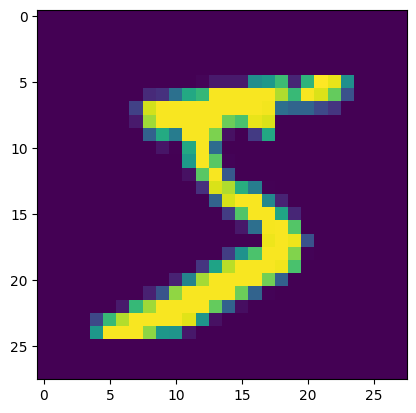

In [182]:
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])
data = MNIST("./data", train=True, download=True, transform=transform)
# print(len(data))
plt.imshow(torch.permute(data[0][0], (1, 2, 0)))
plt.show()

48000
12000
torch.Size([1280, 784])
torch.Size([1280])
torch.Size([784])


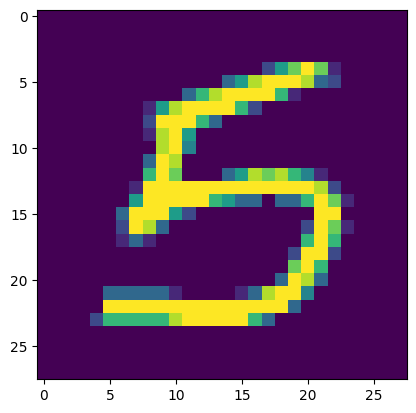

tensor(5)
torch.Size([784])


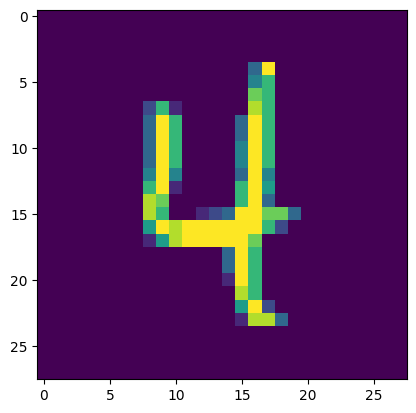

tensor(4)
torch.Size([784])


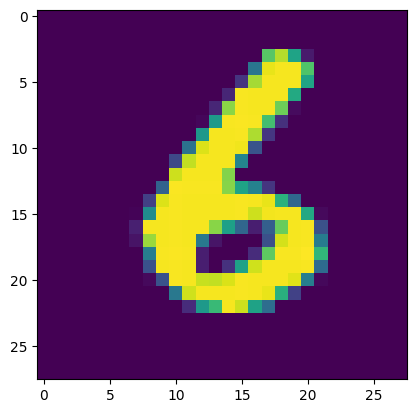

tensor(6)


In [205]:
# dataset & dataloader
# N, H, W = data.data.shape
def reshape_batch(batch):
    features, labels = [], []
    for i in batch:
        features.append(i[0].reshape(1, -1))
        labels.append(i[1])
    return torch.cat(features, 0), torch.tensor(labels, dtype=torch.long)

# data.data = data.data.reshape(N, H*W)
trainDataset, valDataset = torch.utils.data.random_split(data, [48000, len(data)-48000])

print(len(trainDataset))
print(len(valDataset))
trainLoader = DataLoader(trainDataset, shuffle=True, batch_size=1280, collate_fn=reshape_batch)
valLoader = DataLoader(valDataset, shuffle=True, batch_size=128, collate_fn=reshape_batch)

for x, y in trainLoader:
    print(x.shape)
    print(y.shape)
    for i in range(3):
        print(x[i].shape)
        pic = x[i].reshape(28, 28, 1)
        plt.imshow(pic)
        plt.show()
        print(y[i])
    break

In [206]:
class MNIST_ClassficationModel(nn.Module):
    def __init__(self):
        super(MNIST_ClassficationModel, self).__init__()
        self.fc1 = nn.Linear(784, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 10)
        self.relu = nn.ReLU()
    
    def forward(self, x):
#         print(x.shape)
#         print(x.dtype)
        x = self.fc1(x)
        x = self.relu( self.fc2(x) )
        x = self.fc3(x)
        return x

model = MNIST_ClassficationModel()
summary(model, input_size=(128, 784))

Layer (type:depth-idx)                   Output Shape              Param #
MNIST_ClassficationModel                 [128, 10]                 --
├─Linear: 1-1                            [128, 512]                401,920
├─Linear: 1-2                            [128, 128]                65,664
├─ReLU: 1-3                              [128, 128]                --
├─Linear: 1-4                            [128, 10]                 1,290
Total params: 468,874
Trainable params: 468,874
Non-trainable params: 0
Total mult-adds (M): 60.02
Input size (MB): 0.40
Forward/backward pass size (MB): 0.67
Params size (MB): 1.88
Estimated Total Size (MB): 2.94

In [207]:
def getDevice():
    if torch.cuda.is_available():
        device = torch.device('cuda:0')
        print("Use GPU: {}".format(torch.cuda.get_device_name(device)))
    else:
        device = torch.device('cpu')
        print("Use CPU")
    return device

In [208]:
def getModel():
    model = MNIST_ClassficationModel()

In [209]:
def process_batch(device, model, optimizer, criterion, loader, mode="train", accuracy=False):
    loss_sum = 0
    if accuracy:
        dataCount = 0
        acc_sum = 0
    
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        prediction = model(x)
        loss = criterion(prediction, y)
        
        loss_sum += loss.item()
        if accuracy:
            dataCount += len(x)
            acc_sum += (prediction.argmax(1)==y).sum()
        
        if mode=='train':
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
    
    if accuracy:
        return loss_sum/len(loader), (acc_sum/dataCount*100).item()
    else:
        return loss_sum/len(loader)

In [216]:
def fit(device, epochs, model, optimizer, criterion, trainLoader, valLoader, accuracy=False):
    
    train_loss_list, train_acc_list = [], []
    val_loss_list, val_acc_list = [], []
    
    for i in range(epochs):
        
        # train set
        model.train()
        if accuracy:
            loss, acc = process_batch(device, model, optimizer, criterion, trainLoader, mode='train', accuracy=True)
            train_acc_list.append(acc)
        else:
            loss = process_batch(device, model, optimizer, criterion, trainLoader, mode='train', accuracy=False)
        train_loss_list.append(loss)
        
        # validation set
        model.eval()
        if accuracy:
            loss, acc = process_batch(device, model, optimizer, criterion, trainLoader, mode='val', accuracy=True)
            val_acc_list.append(acc)
        else:
            loss = process_batch(device, model, optimizer, criterion, trainLoader, mode='val', accuracy=False)
        val_loss_list.append(loss)
        
        
        # plot loss
        plt.figure(figsize=(8, 3))
        plt.title("Loss")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.plot(range(i+1), train_loss_list, label='train')
        plt.plot(range(i+1), val_loss_list, label='val')
        plt.legend(loc="upper left")
        plt.show()
        
        # plot acc
        if accuracy:
            plt.figure(figsize=(8, 3))
            plt.title("Accuracy")
            plt.xlabel("Epoch")
            plt.ylabel("Accuracy")
            plt.plot(range(i+1), train_acc_list, label='train')
            plt.plot(range(i+1), val_acc_list, label='val')
            plt.legend(loc="upper left")
            plt.show()
        
            print("Train loss: {:.10f}       Train Acc: {:.10f}%".format(train_loss_list[-1], train_acc_list[-1]))
            print("Val   loss: {:.10f}       Val   Acc: {:.10f}%".format(val_loss_list[-1], val_acc_list[-1]))
        else:
            print("Train loss: {:.10f}".format(train_loss_list[-1]))
            print("Val   loss: {:.10f}".format(val_loss_list[-1]))
        print("\n\n\n")


Use GPU: NVIDIA GeForce RTX 3060


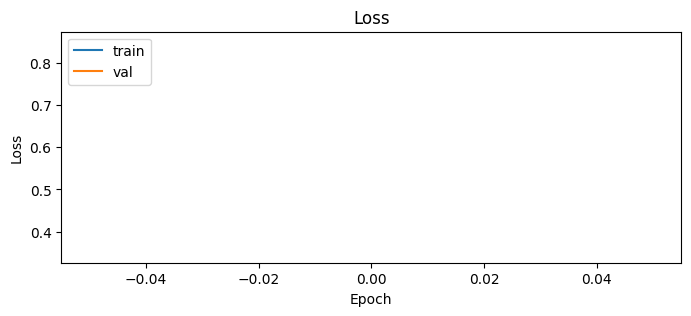

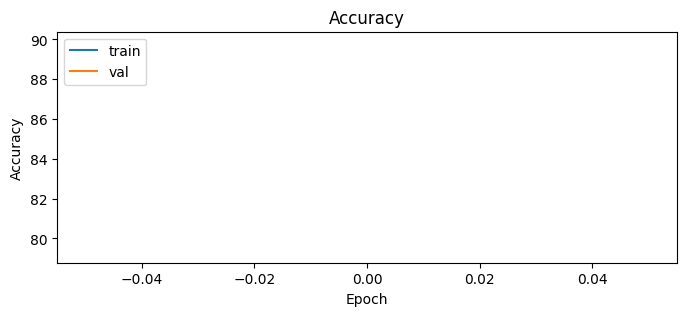

Train loss: 0.8488956306       Train Acc: 79.3083343506%
Val   loss: 0.3511211174       Val   Acc: 89.8604125977%






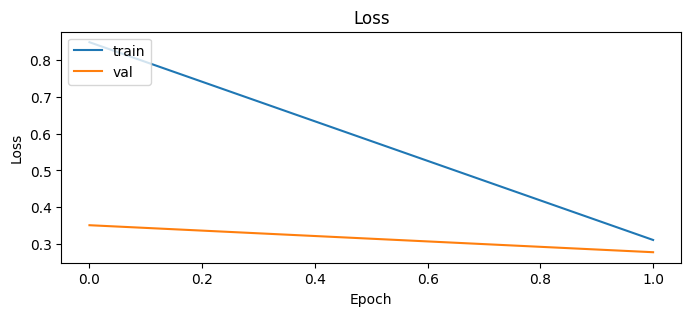

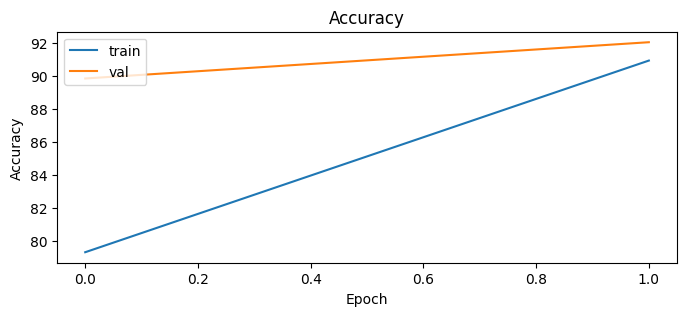

Train loss: 0.3110003942       Train Acc: 90.9479141235%
Val   loss: 0.2776614918       Val   Acc: 92.0625000000%






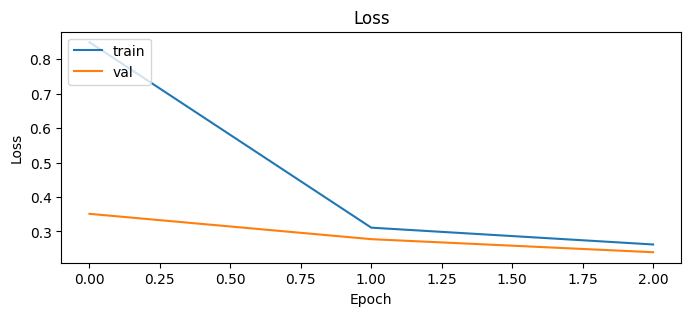

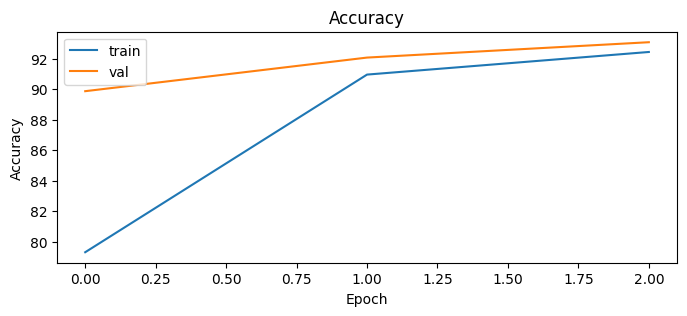

Train loss: 0.2622399005       Train Acc: 92.4291687012%
Val   loss: 0.2397653410       Val   Acc: 93.0687484741%






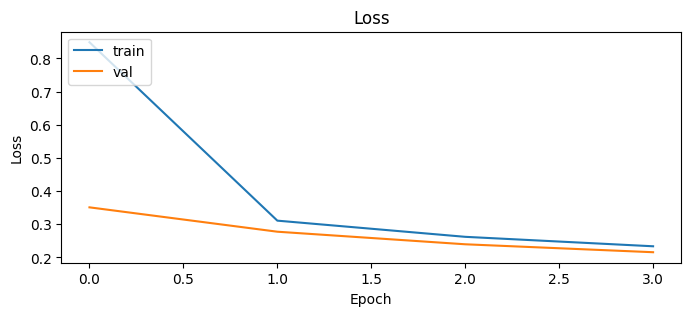

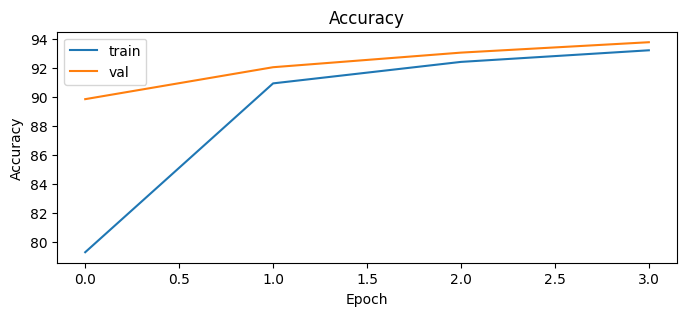

Train loss: 0.2337458314       Train Acc: 93.2291641235%
Val   loss: 0.2158266624       Val   Acc: 93.7854156494%






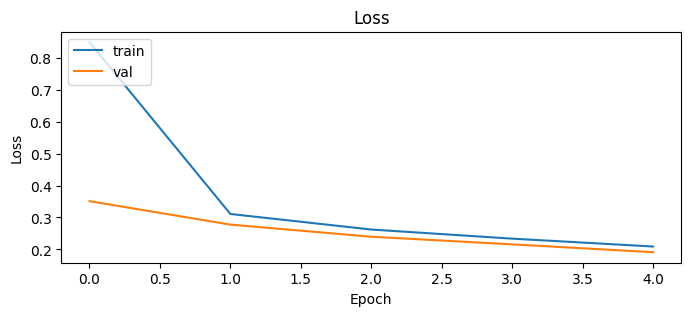

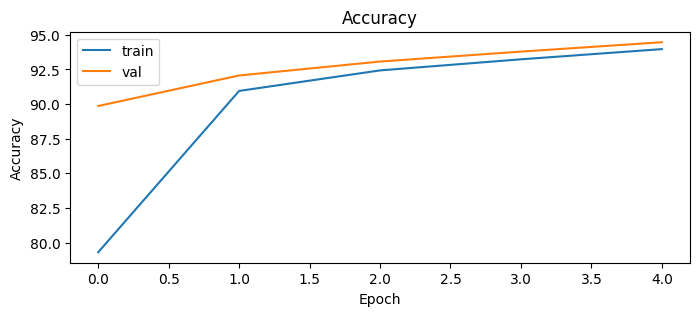

Train loss: 0.2090606356       Train Acc: 93.9645843506%
Val   loss: 0.1911970855       Val   Acc: 94.4624938965%






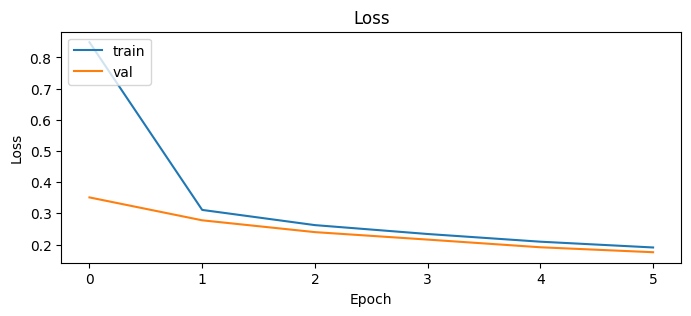

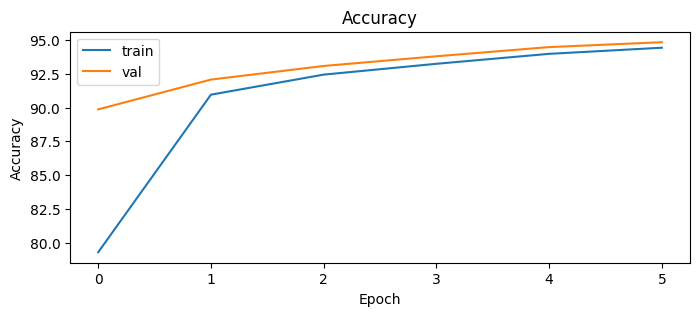

Train loss: 0.1905315213       Train Acc: 94.4166641235%
Val   loss: 0.1752979716       Val   Acc: 94.8229141235%






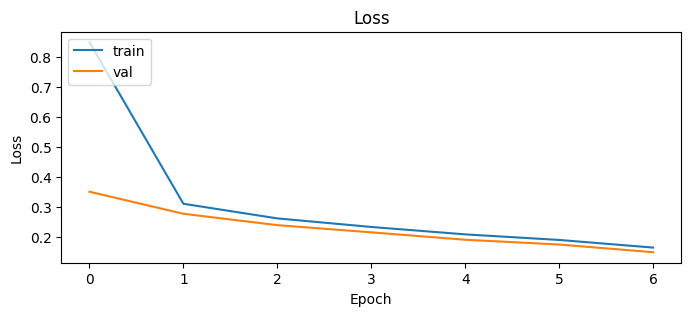

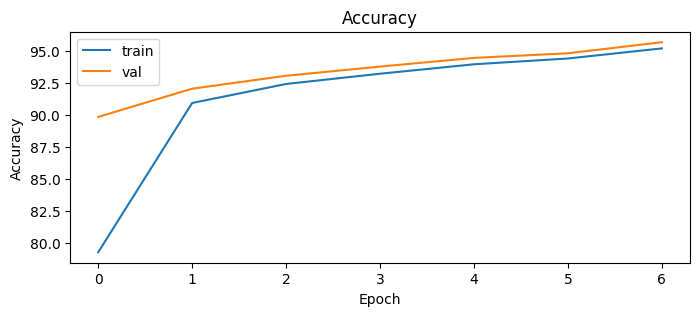

Train loss: 0.1650977860       Train Acc: 95.2041702271%
Val   loss: 0.1496402531       Val   Acc: 95.6854171753%






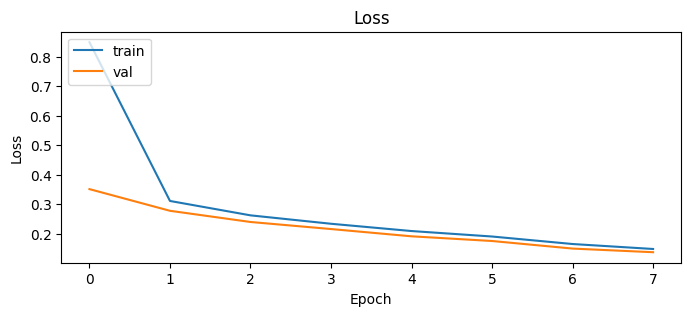

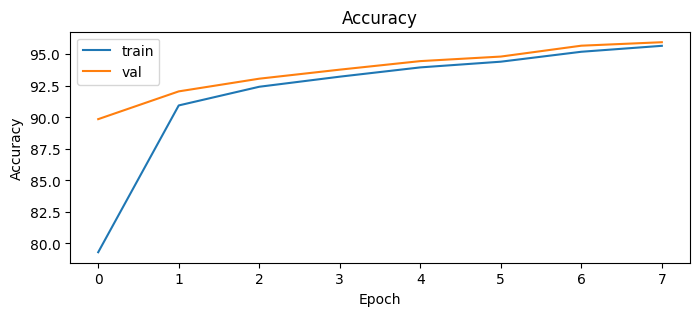

Train loss: 0.1482804392       Train Acc: 95.6749954224%
Val   loss: 0.1372966831       Val   Acc: 95.9604110718%






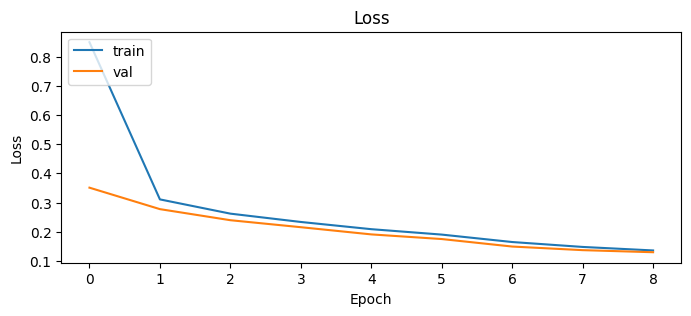

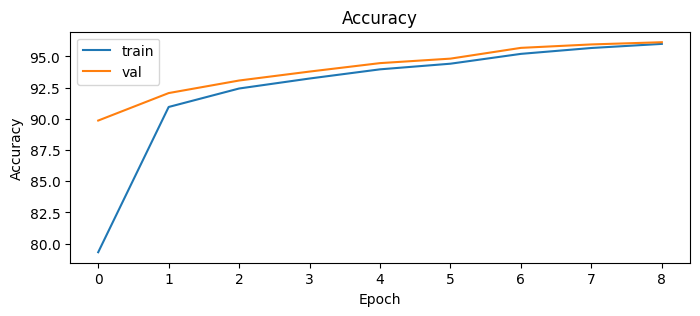

Train loss: 0.1362739429       Train Acc: 96.0041656494%
Val   loss: 0.1302004496       Val   Acc: 96.1374969482%






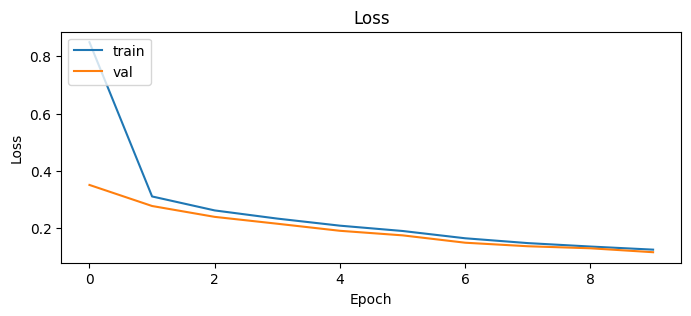

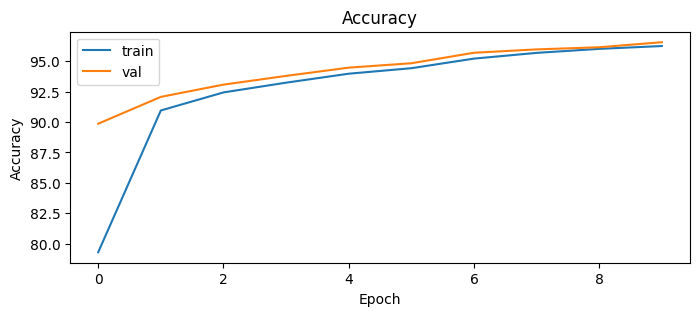

Train loss: 0.1254534263       Train Acc: 96.2374954224%
Val   loss: 0.1164717884       Val   Acc: 96.5500030518%






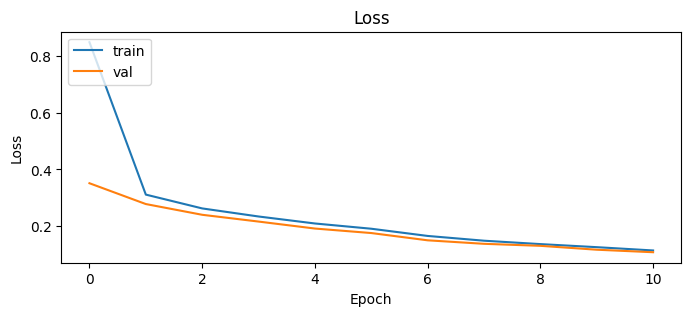

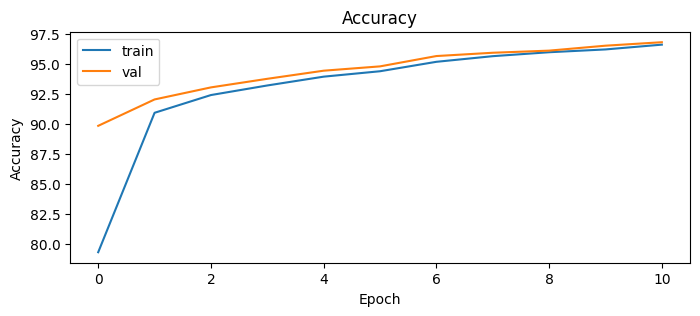

Train loss: 0.1138225766       Train Acc: 96.6374969482%
Val   loss: 0.1076126948       Val   Acc: 96.8395843506%






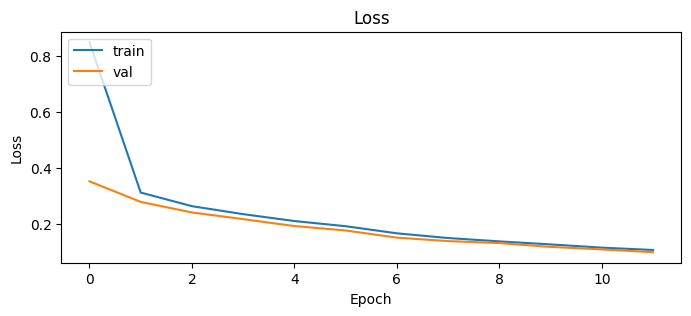

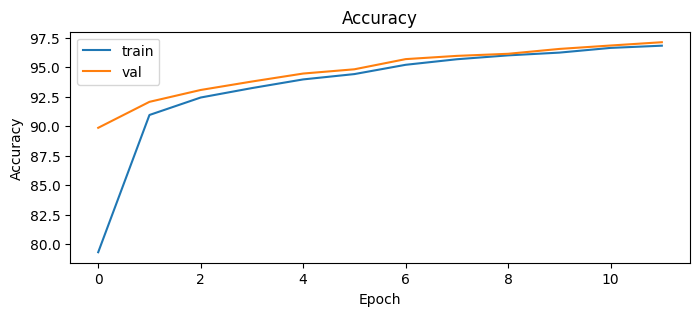

Train loss: 0.1054917719       Train Acc: 96.8249969482%
Val   loss: 0.0974883627       Val   Acc: 97.1187438965%






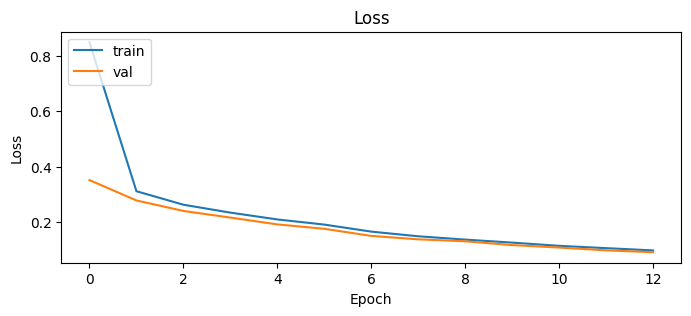

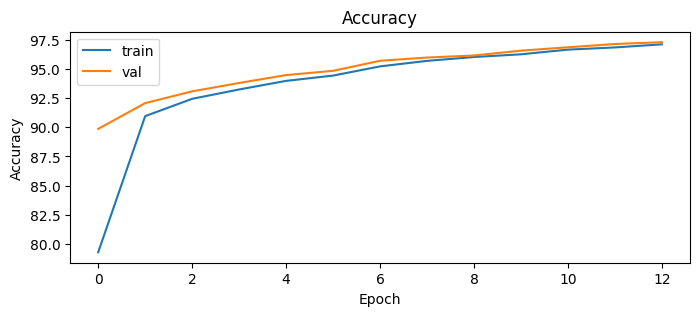

Train loss: 0.0972422497       Train Acc: 97.0895843506%
Val   loss: 0.0907449420       Val   Acc: 97.2708358765%






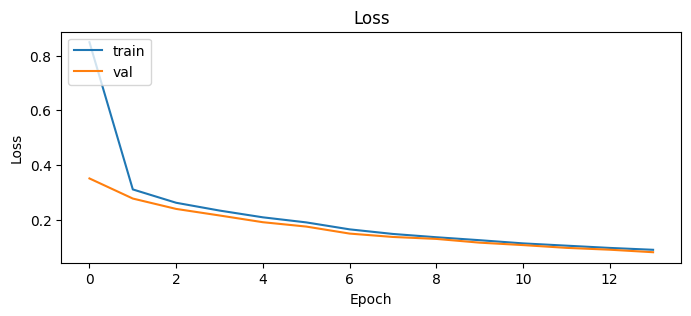

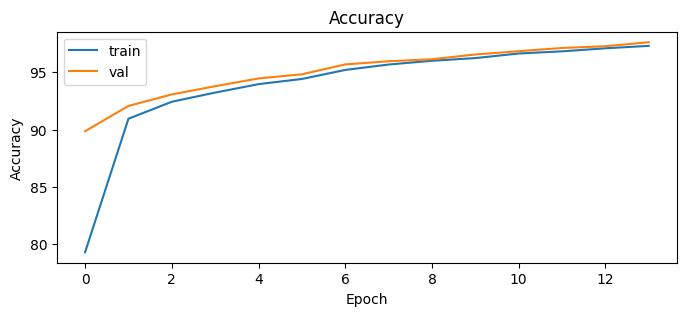

Train loss: 0.0903941173       Train Acc: 97.3041687012%
Val   loss: 0.0815372078       Val   Acc: 97.6208343506%






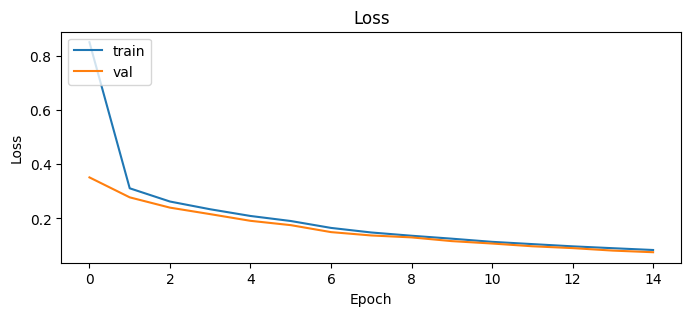

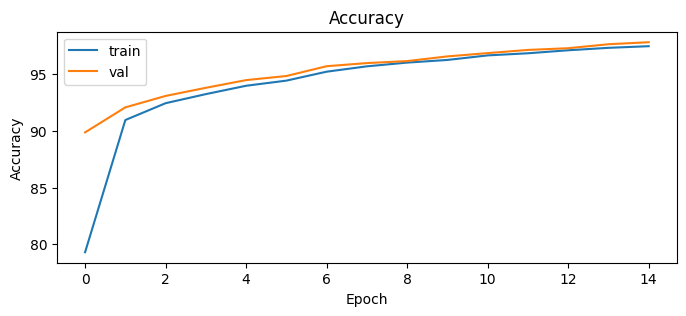

Train loss: 0.0837820485       Train Acc: 97.4479141235%
Val   loss: 0.0755852846       Val   Acc: 97.7979202271%






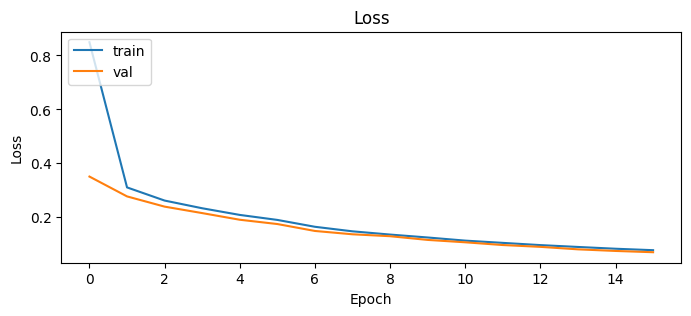

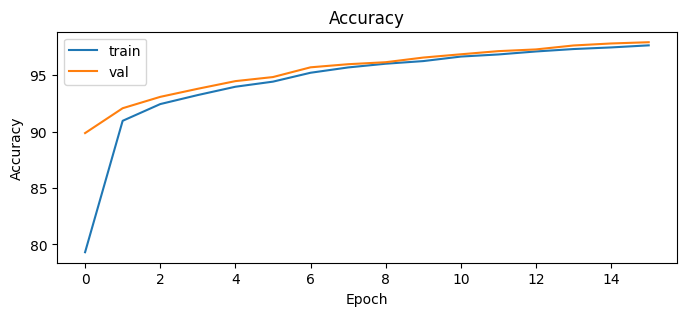

Train loss: 0.0784116254       Train Acc: 97.6312484741%
Val   loss: 0.0708597616       Val   Acc: 97.9083328247%






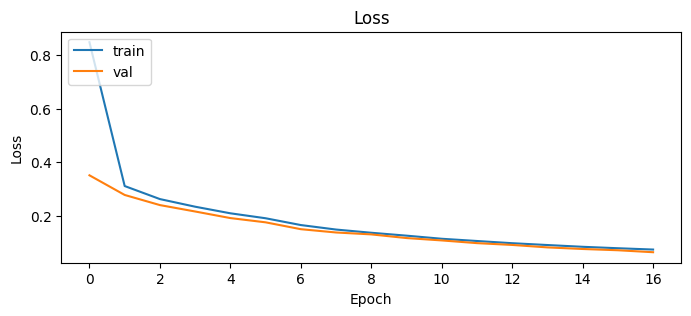

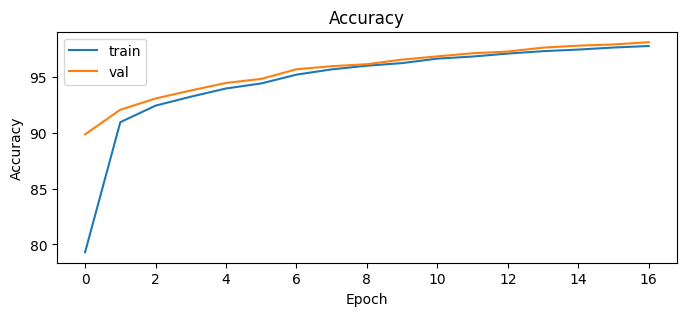

Train loss: 0.0734911317       Train Acc: 97.7687454224%
Val   loss: 0.0634922738       Val   Acc: 98.1062469482%






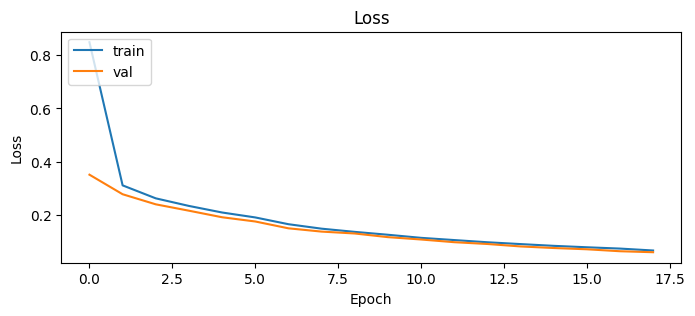

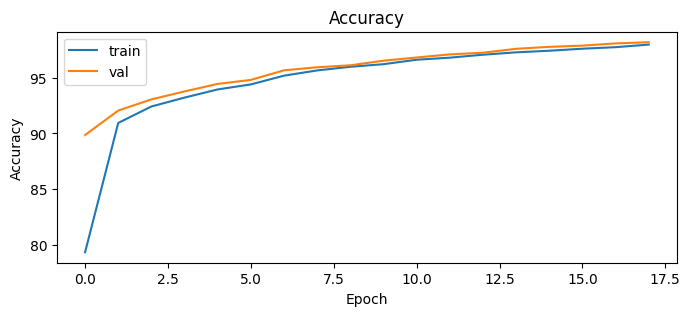

Train loss: 0.0662860714       Train Acc: 98.0020828247%
Val   loss: 0.0597920181       Val   Acc: 98.2145843506%






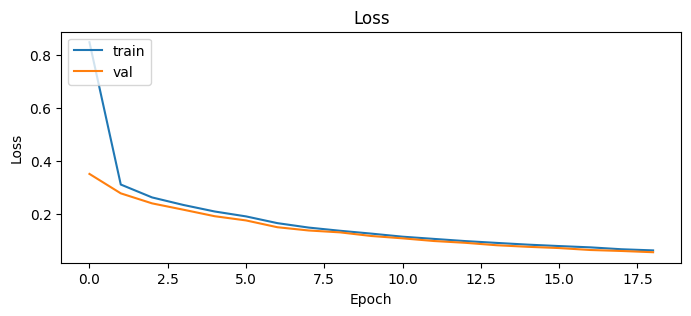

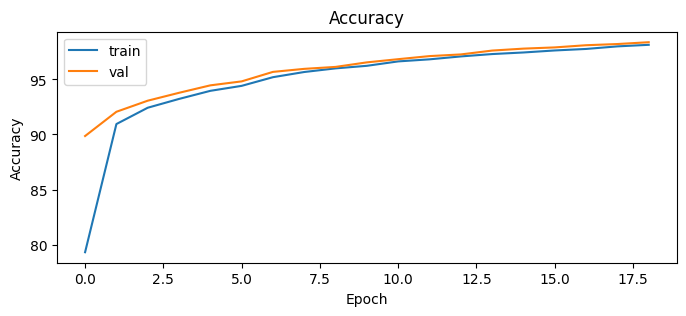

Train loss: 0.0620416465       Train Acc: 98.1437530518%
Val   loss: 0.0551288452       Val   Acc: 98.3791656494%






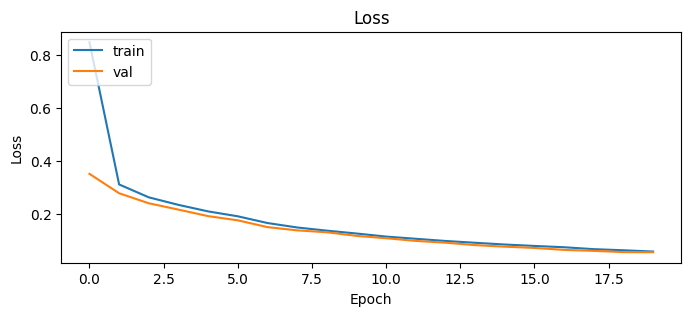

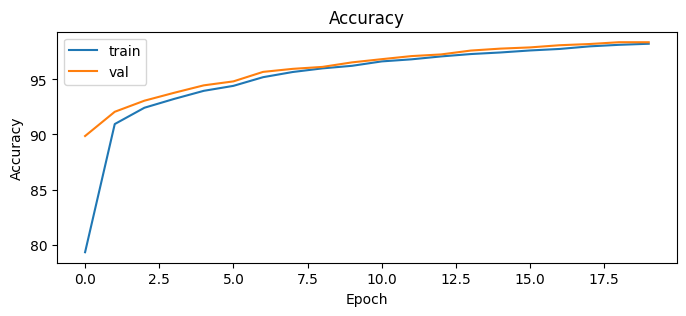

Train loss: 0.0572307693       Train Acc: 98.2395858765%
Val   loss: 0.0546593635       Val   Acc: 98.3770828247%






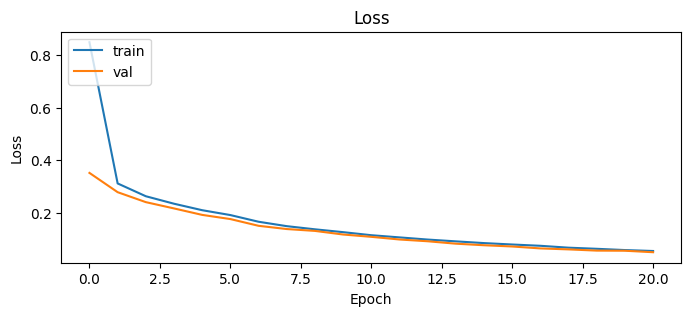

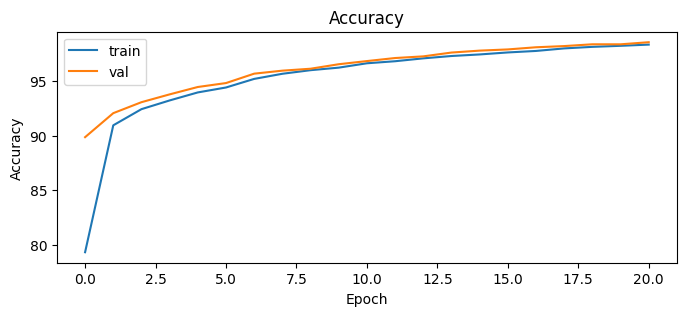

Train loss: 0.0536570008       Train Acc: 98.3499984741%
Val   loss: 0.0490022321       Val   Acc: 98.5687484741%






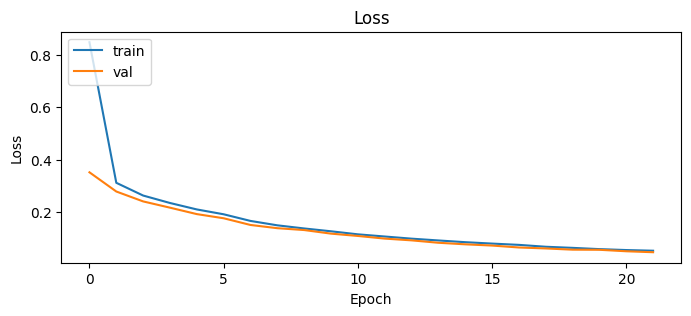

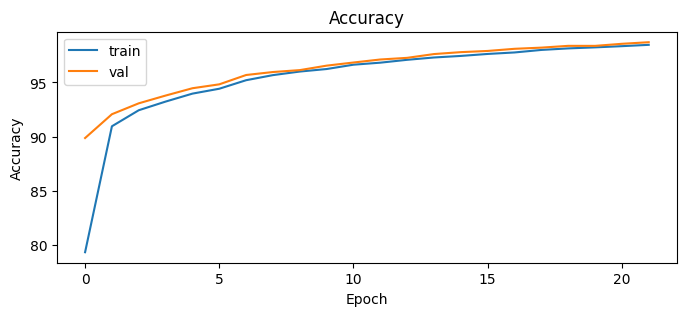

Train loss: 0.0511157327       Train Acc: 98.4729156494%
Val   loss: 0.0453553641       Val   Acc: 98.7145843506%






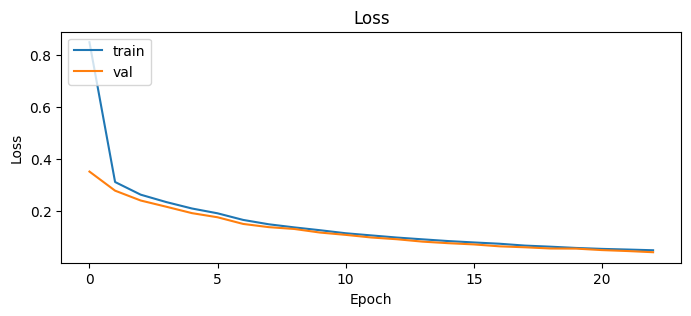

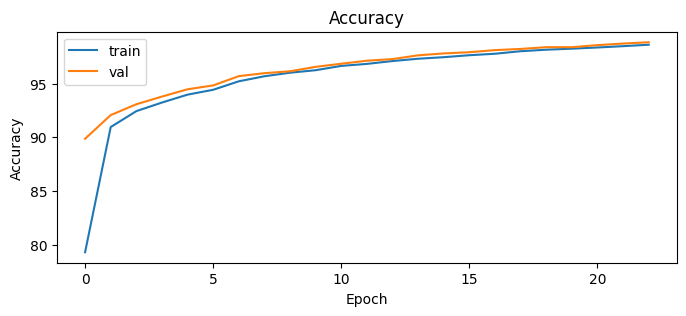

Train loss: 0.0483766045       Train Acc: 98.6083297729%
Val   loss: 0.0407972579       Val   Acc: 98.8395843506%






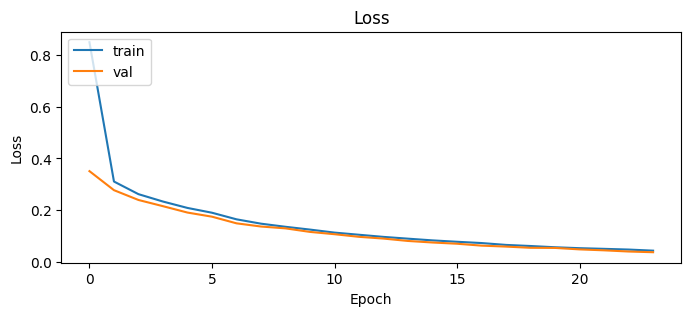

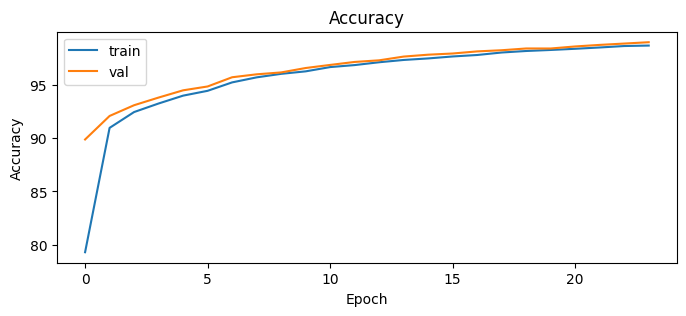

Train loss: 0.0441139090       Train Acc: 98.6520843506%
Val   loss: 0.0380689811       Val   Acc: 98.9645843506%






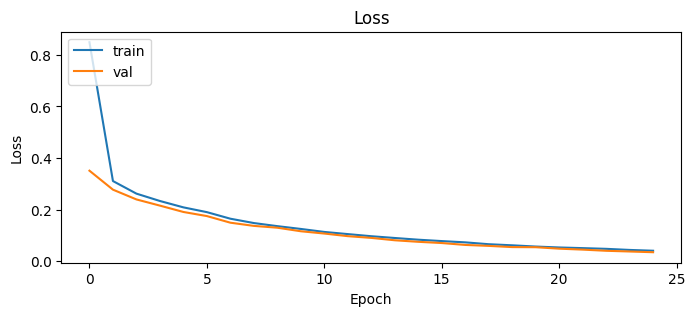

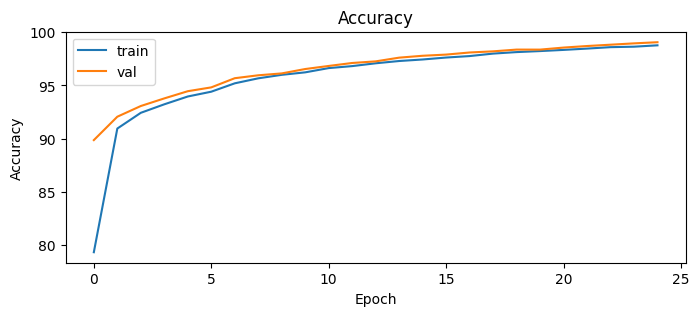

Train loss: 0.0410000875       Train Acc: 98.7812500000%
Val   loss: 0.0352423778       Val   Acc: 99.0729141235%






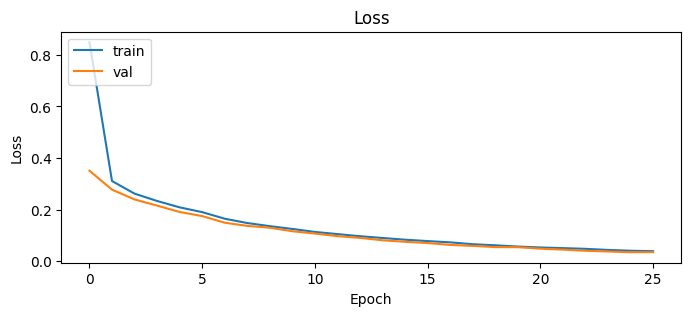

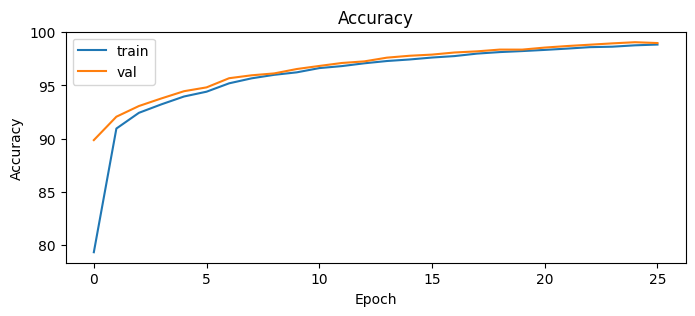

Train loss: 0.0392263067       Train Acc: 98.8541641235%
Val   loss: 0.0356416246       Val   Acc: 98.9958343506%






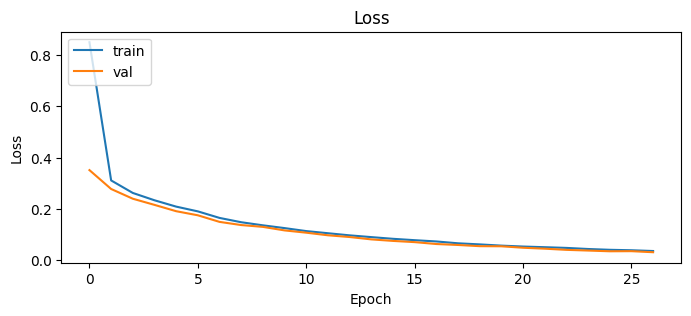

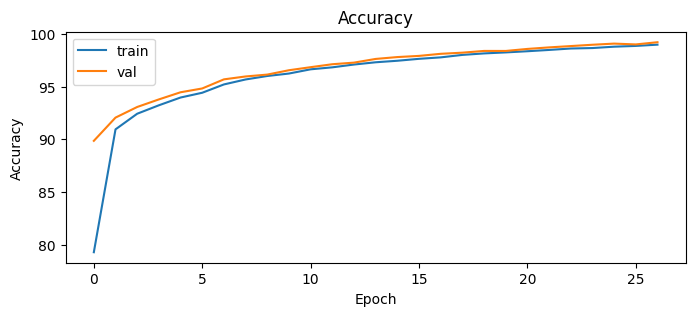

Train loss: 0.0362615130       Train Acc: 98.9729156494%
Val   loss: 0.0315654133       Val   Acc: 99.2041625977%






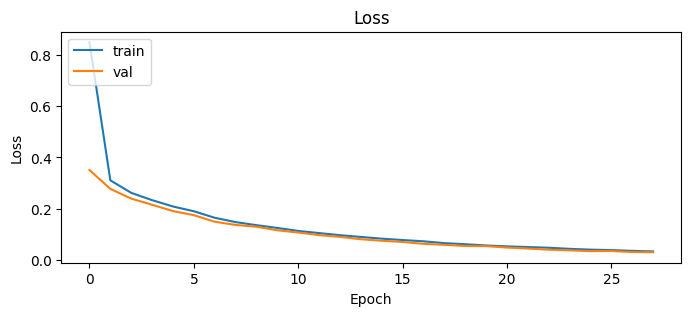

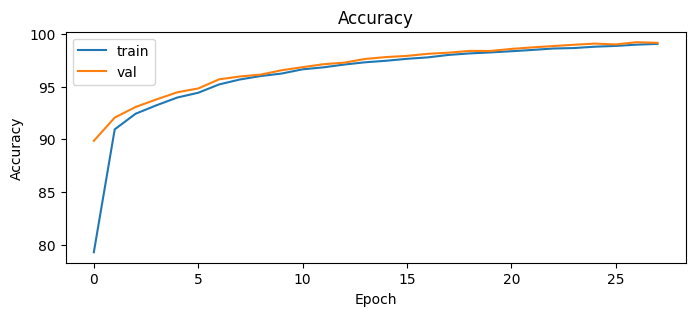

Train loss: 0.0340047787       Train Acc: 99.0458297729%
Val   loss: 0.0309135200       Val   Acc: 99.1479187012%






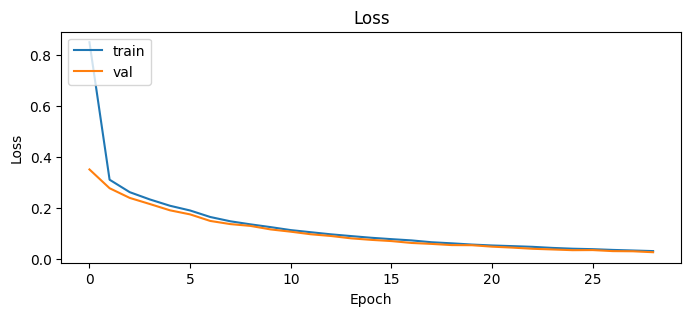

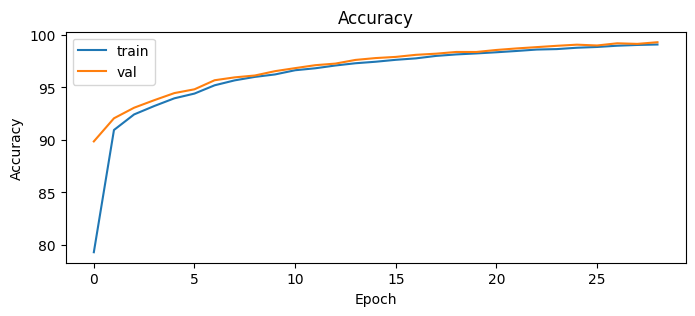

Train loss: 0.0316798377       Train Acc: 99.0895843506%
Val   loss: 0.0272465705       Val   Acc: 99.3062515259%






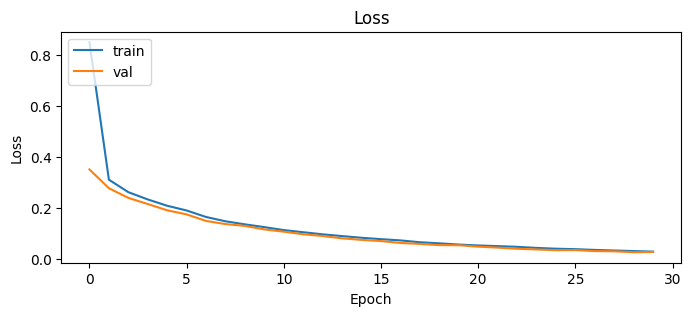

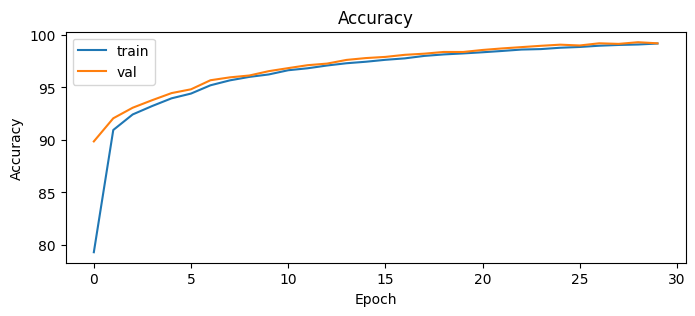

Train loss: 0.0295778596       Train Acc: 99.1812438965%
Val   loss: 0.0282771382       Val   Acc: 99.2020874023%






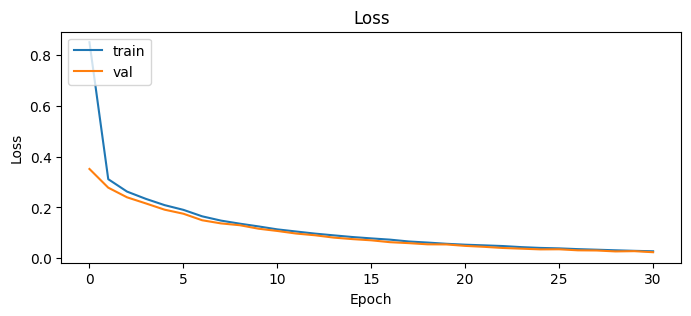

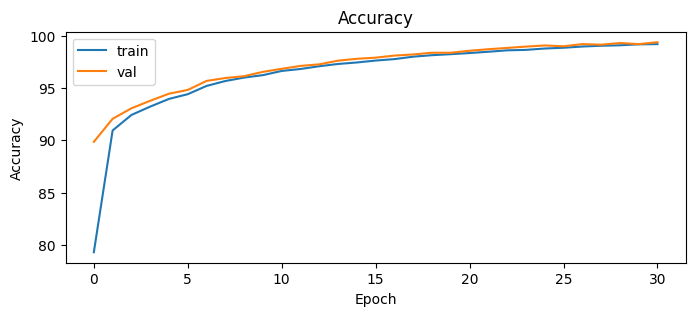

Train loss: 0.0278088250       Train Acc: 99.2020874023%
Val   loss: 0.0241137401       Val   Acc: 99.3833312988%






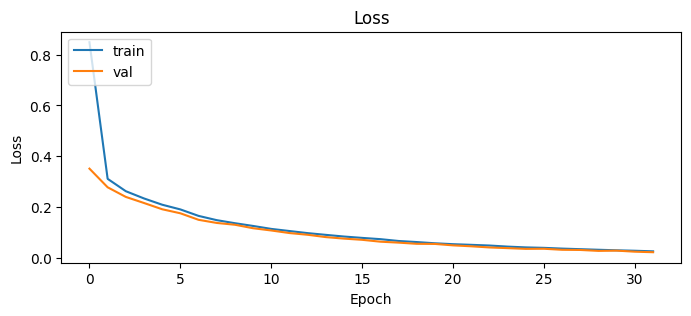

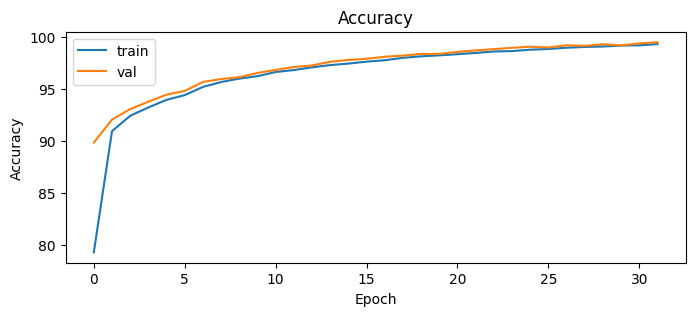

Train loss: 0.0255173418       Train Acc: 99.3250045776%
Val   loss: 0.0220117130       Val   Acc: 99.5020828247%






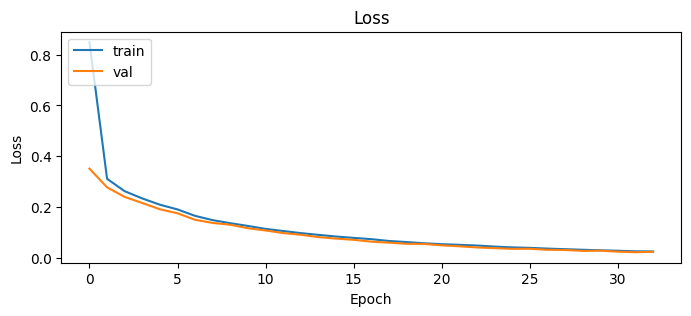

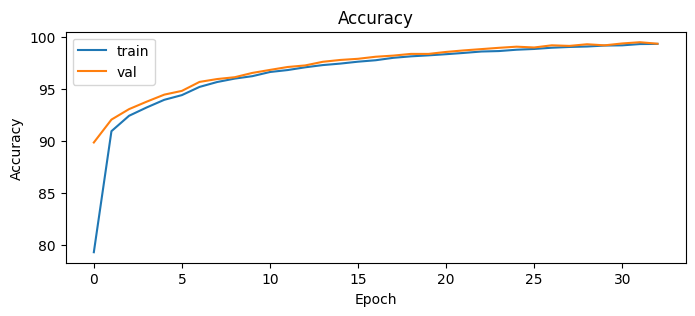

Train loss: 0.0250120575       Train Acc: 99.3395843506%
Val   loss: 0.0237364173       Val   Acc: 99.3583297729%






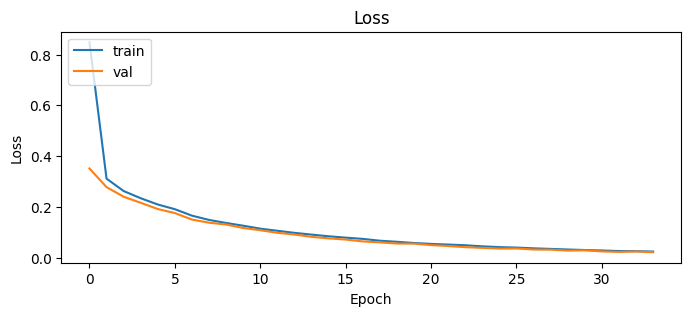

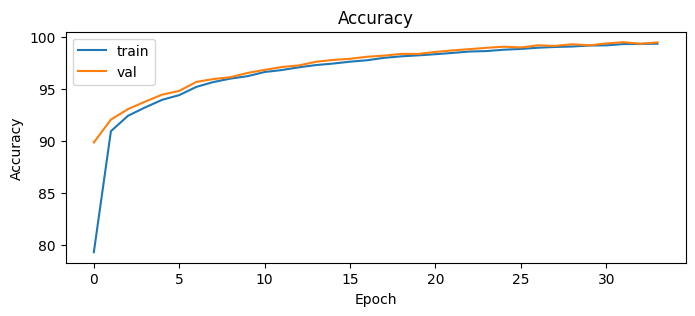

Train loss: 0.0235491847       Train Acc: 99.3541641235%
Val   loss: 0.0208944221       Val   Acc: 99.4833374023%






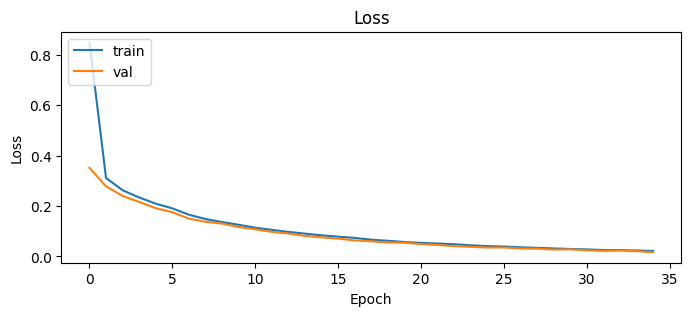

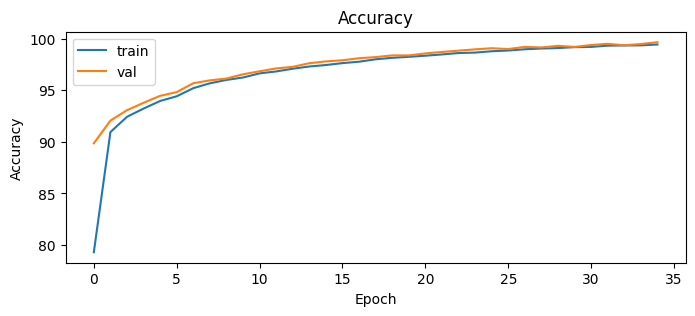

Train loss: 0.0216761108       Train Acc: 99.4354095459%
Val   loss: 0.0167148037       Val   Acc: 99.6562500000%






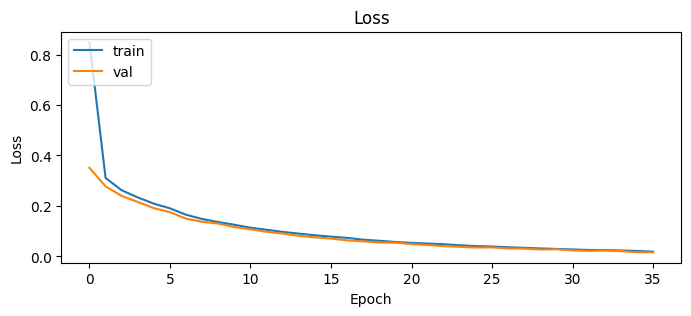

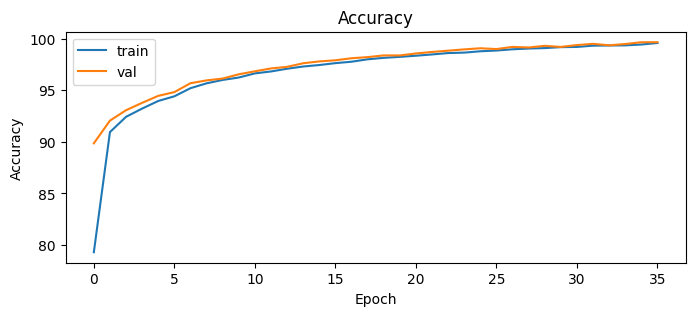

Train loss: 0.0190685769       Train Acc: 99.5812454224%
Val   loss: 0.0166424898       Val   Acc: 99.6583328247%






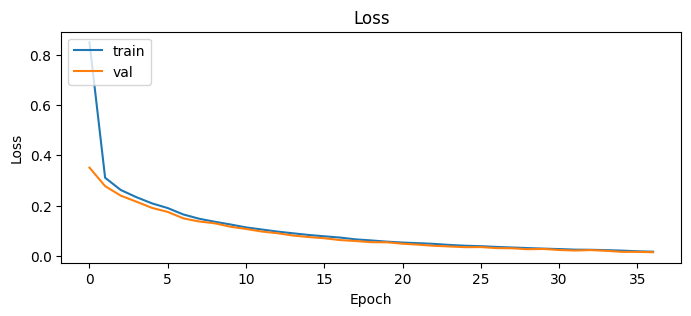

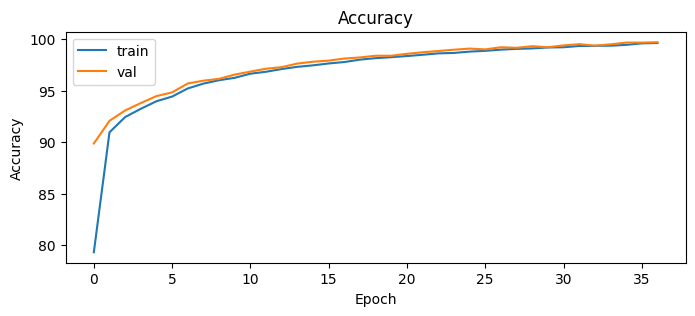

Train loss: 0.0173215608       Train Acc: 99.6145858765%
Val   loss: 0.0152629452       Val   Acc: 99.6916656494%






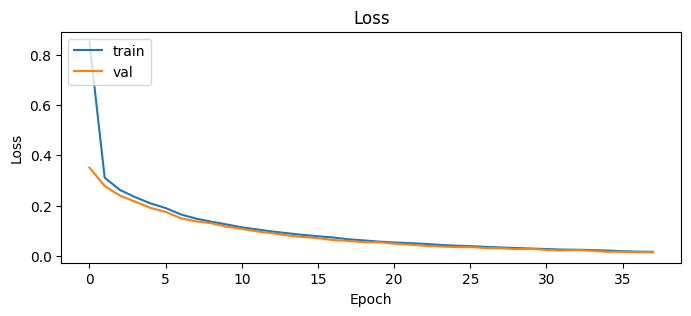

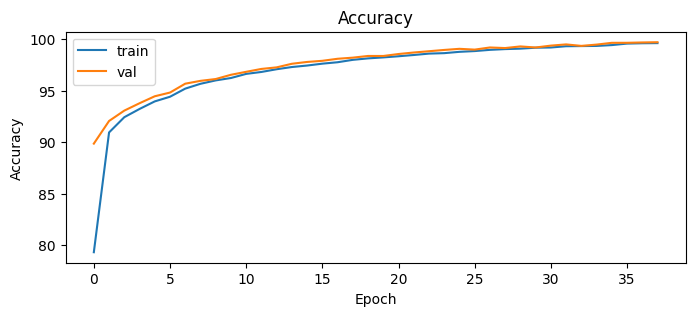

Train loss: 0.0166143359       Train Acc: 99.6270828247%
Val   loss: 0.0150206771       Val   Acc: 99.7145843506%






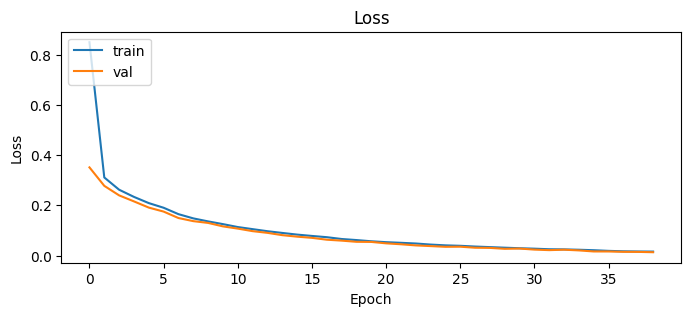

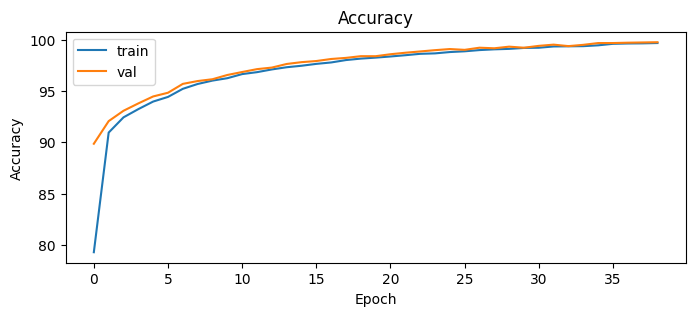

Train loss: 0.0162139223       Train Acc: 99.6583328247%
Val   loss: 0.0136888711       Val   Acc: 99.7375030518%






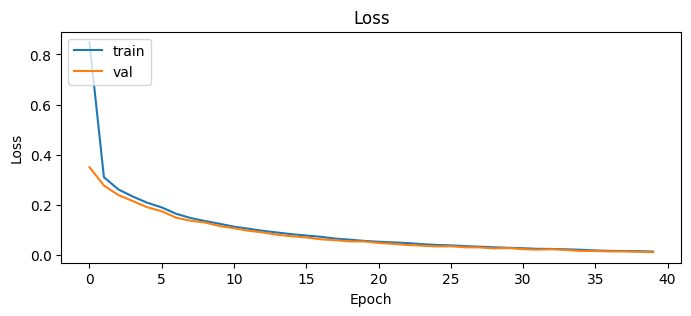

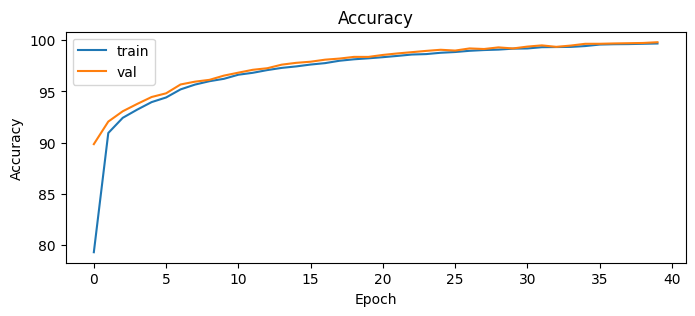

Train loss: 0.0144256394       Train Acc: 99.6854095459%
Val   loss: 0.0119178757       Val   Acc: 99.8104171753%






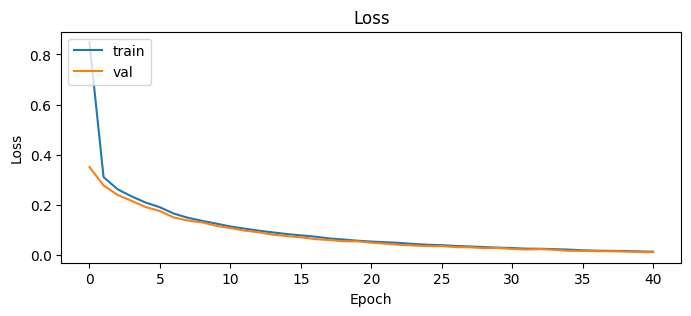

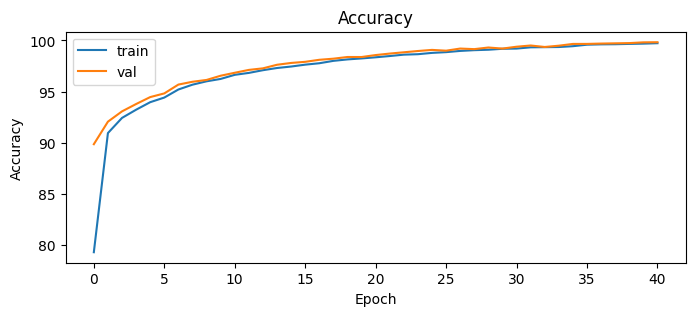

Train loss: 0.0135494737       Train Acc: 99.7270812988%
Val   loss: 0.0112070055       Val   Acc: 99.8229141235%






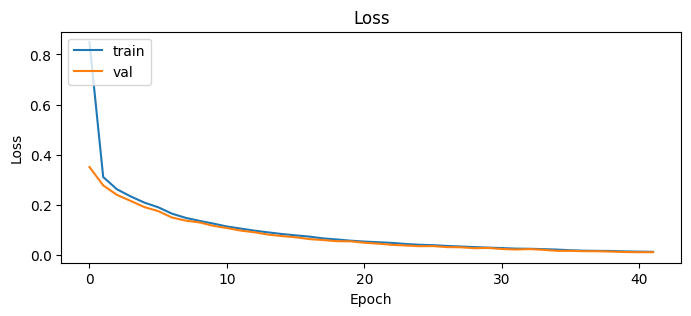

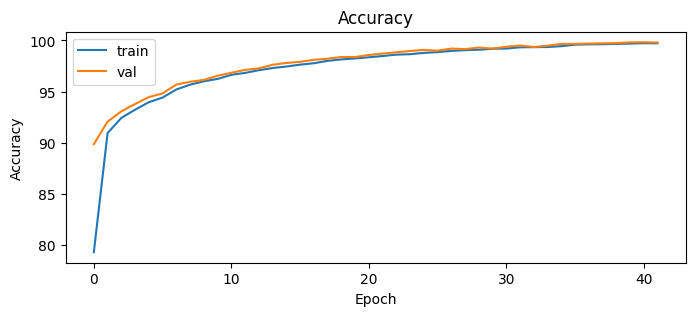

Train loss: 0.0128521311       Train Acc: 99.7145843506%
Val   loss: 0.0112549515       Val   Acc: 99.7874984741%






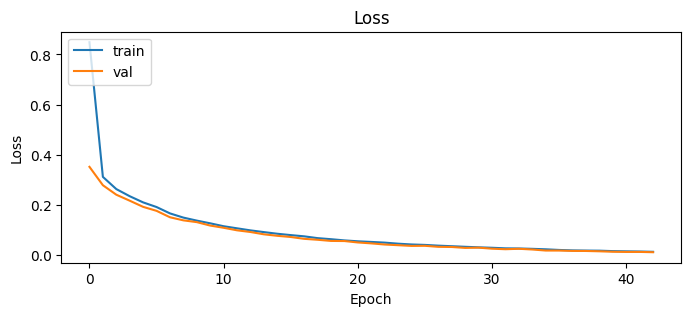

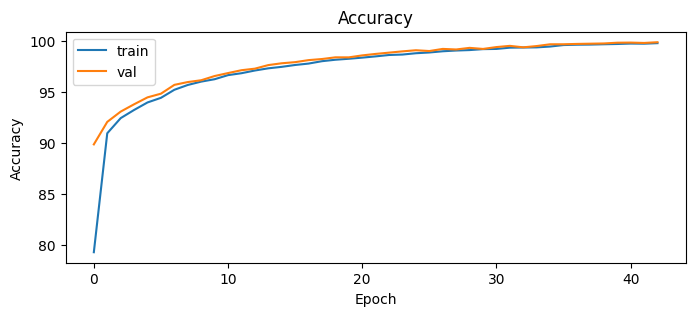

Train loss: 0.0116725169       Train Acc: 99.7666625977%
Val   loss: 0.0100117368       Val   Acc: 99.8583297729%






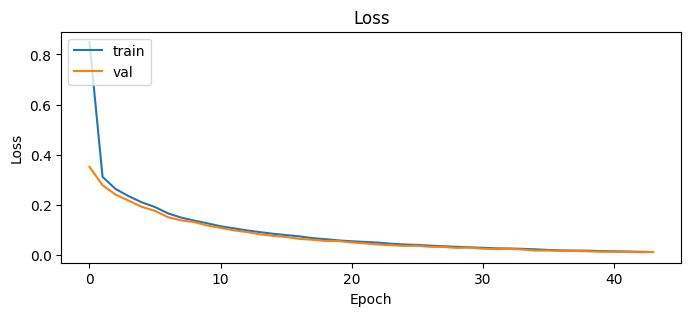

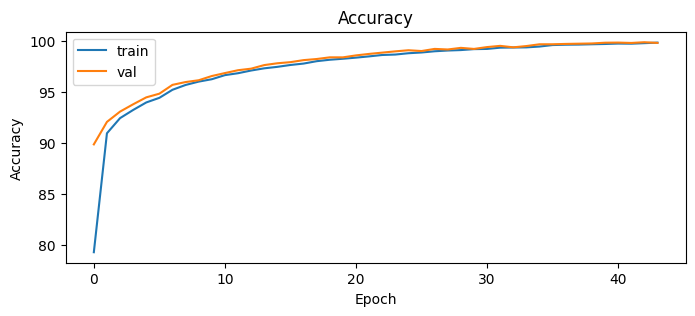

Train loss: 0.0107535850       Train Acc: 99.8187484741%
Val   loss: 0.0107422286       Val   Acc: 99.7895812988%






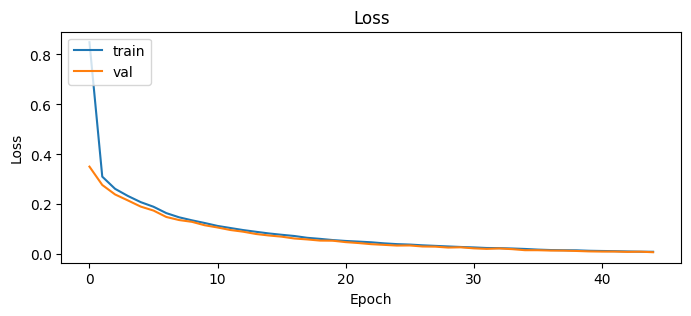

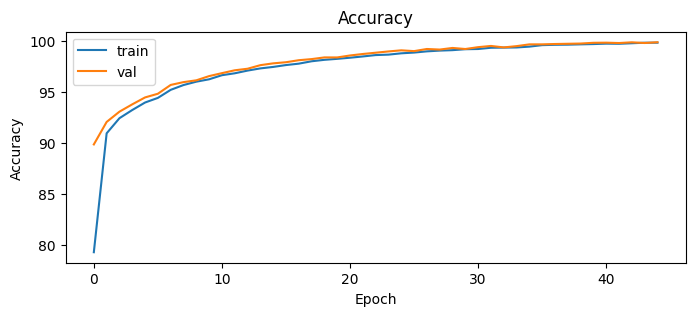

Train loss: 0.0104066517       Train Acc: 99.8208312988%
Val   loss: 0.0085962838       Val   Acc: 99.8666610718%






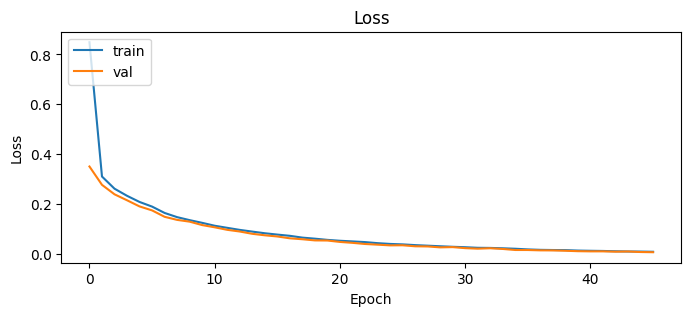

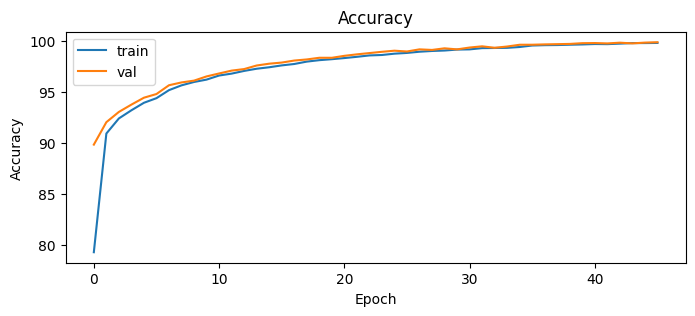

Train loss: 0.0095903781       Train Acc: 99.8333358765%
Val   loss: 0.0077959422       Val   Acc: 99.9041671753%






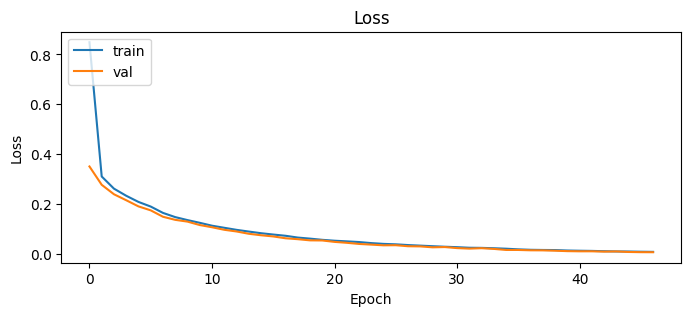

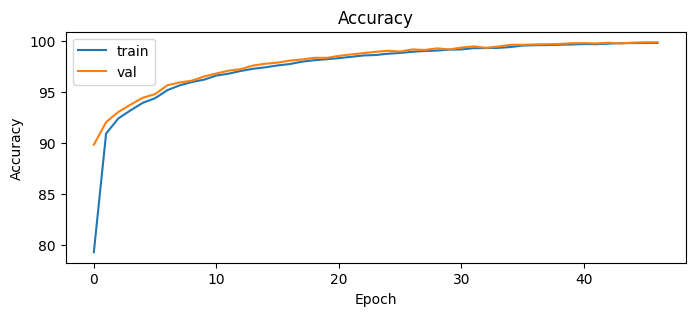

Train loss: 0.0089922171       Train Acc: 99.8416671753%
Val   loss: 0.0075763709       Val   Acc: 99.9083328247%






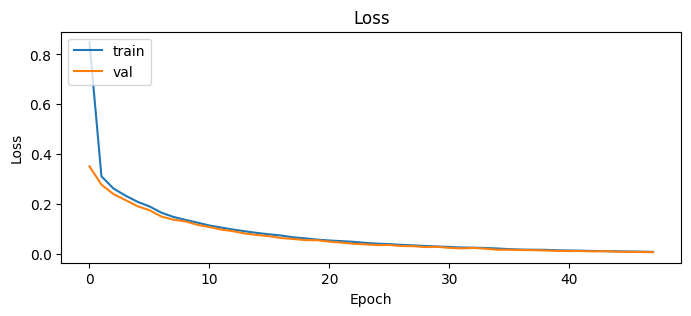

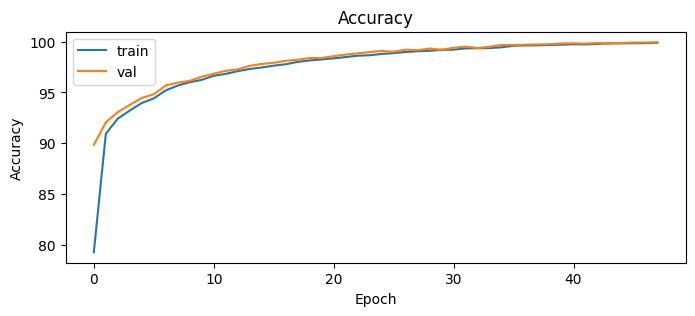

Train loss: 0.0079602221       Train Acc: 99.8833312988%
Val   loss: 0.0066220920       Val   Acc: 99.9312438965%






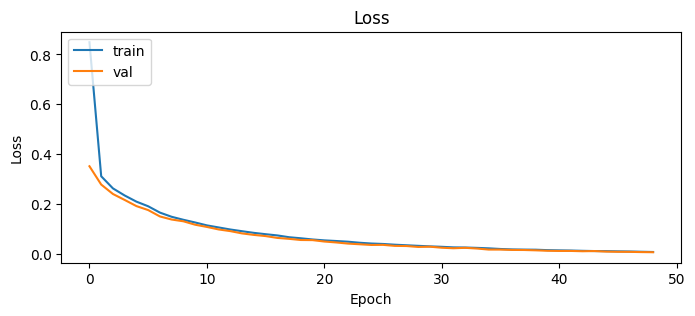

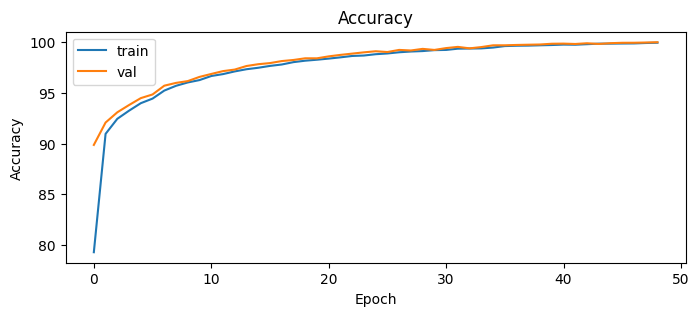

Train loss: 0.0069823070       Train Acc: 99.9104156494%
Val   loss: 0.0060780102       Val   Acc: 99.9604187012%






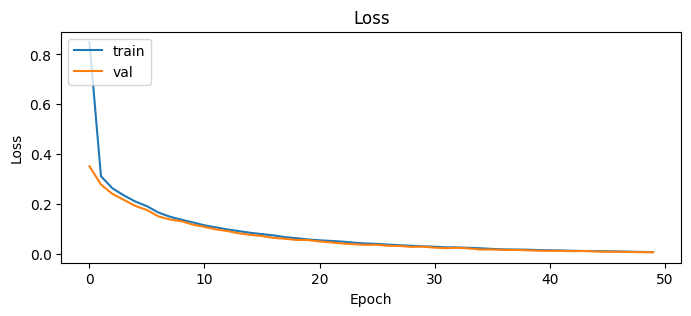

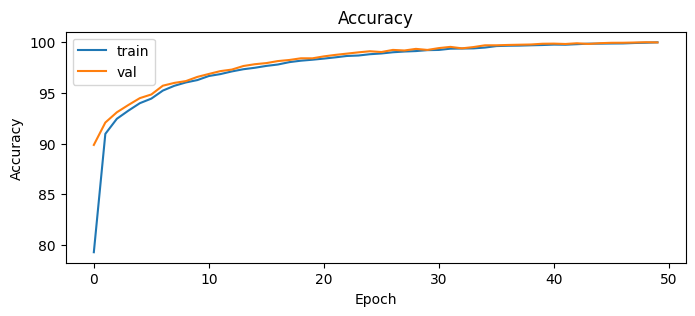

Train loss: 0.0063563190       Train Acc: 99.9479141235%
Val   loss: 0.0058185895       Val   Acc: 99.9395828247%






In [217]:
device = getDevice()
model = MNIST_ClassficationModel().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
fit(device, 50, model, optimizer, criterion, trainLoader, valLoader, accuracy=True)

In [218]:
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])
test_data = MNIST("./data", train=False, download=True, transform=transform)
testLoader = DataLoader(test_data, batch_size=128, collate_fn=reshape_batch)

correct = 0
for x, y in testLoader:
    x, y = x.to(device), y.to(device)
    predicts = model(x)
    correct += ((predicts.argmax(dim=1)==y).sum()).item()
print(correct/len(test_data))

0.9726
